In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
%cd '/content/gdrive/MyDrive/AI Insight/Week14'
! ls

/content/gdrive/MyDrive/AI Insight/Week14
21.1.UNet-Architecture.ipynb  21.2_19.h5  21.2_5.h5
21.2_10.h5		      21.2_1.h5   21.2_8.h5
21.2_13.h5		      21.2_2.h5   21.2.UNet-Colorization.ipynb
21.2_15.h5		      21.2_3.h5   kitti_test
21.2_18.h5		      21.2_4.h5   kitti_train


In [22]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random

In [4]:
PATH = '/content/gdrive/MyDrive/AI Insight/Week14/'
BUFFER_SIZE = 50
BATCH_SIZE  = 1
IMG_WIDTH   = 1024
IMG_HEIGHT  = 256

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)    
    
    # resize
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # copy
    gray = tf.identity(image)
    color= tf.identity(image)
    
    # convert to gray
    gray = tf.image.rgb_to_grayscale(gray)
    
    gray  = tf.cast(gray, tf.float32)
    color = tf.cast(color, tf.float32) 

    return gray, color

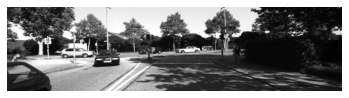

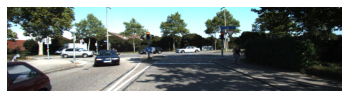

In [5]:
gray, color = load(PATH +'kitti_train/000008_10.png')

# casting to int for matplotlib to show the image
plt.figure()
plt.axis('off')
plt.imshow(gray[:,:,0]/255.0, cmap='gray')

plt.figure()
plt.axis('off')
plt.imshow(color/255.0)

In [23]:
PATH = '/content/gdrive/MyDrive/AI Insight/Week14/'
BUFFER_SIZE = 50
BATCH_SIZE  = 1
IMG_WIDTH   = 1024
IMG_HEIGHT  = 256

def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)    
    
    # resize
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    
    # copy
    gray = tf.identity(image)
    color= tf.identity(image)
    
    # convert to gray
    gray = tf.image.rgb_to_grayscale(gray)
    gray = tf.reshape(gray, (1, 256, 1024, 1))

    edges = tf.image.sobel_edges(gray)
    edges = edges**2

    edges = tf.math.reduce_sum(edges, axis=-1)
    edges = tf.sqrt(edges)
    
    edges  = tf.cast(edges, tf.float32)
    color = tf.cast(color, tf.float32) 

    return edges[0], color

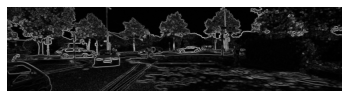

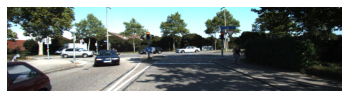

In [24]:
gray, color = load(PATH+'kitti_train/000008_10.png')

# casting to int for matplotlib to show the image
plt.figure()
plt.axis('off')
plt.imshow(gray[:,:,0]/255.0, cmap = 'gray')

plt.figure()
plt.axis('off')
plt.imshow(color/255.0)

In [25]:
# normalizing the images to [-1, 1]
def normalize(gray, color):
    gray  = (gray / 127.5) - 1
    color = (color / 127.5) - 1

    return gray, color

def random_jitter(gray, color):
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        gray  = tf.image.flip_left_right(gray)
        color = tf.image.flip_left_right(color)

    return gray, color

def load_image_train(image_file):
    gray, color = load(image_file)
    gray, color = random_jitter(gray, color)
    gray, color = normalize(gray, color)

    return gray, color

def load_image_test(image_file):
    gray, color = load(image_file)
    gray, color = normalize(gray, color)

    return gray, color

In [26]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(PATH + 'kitti_train/*_10.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# test_dataset
test_dataset = tf.data.Dataset.list_files(PATH + 'kitti_test/0000*_10.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

In [27]:
def extract_first_features(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    return result

def downsample(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    return result

def upsample(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    return result

In [28]:
def UNet_process(x):
    down_stack = [
        downsample(64, 4),  # (bs, 64, 128, 64)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
    ]

    up_stack = [
        upsample(512, 4), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    OUTPUT_CHANNELS = 3
    
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 512, 512, 3)

    concat = tf.keras.layers.Concatenate()
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)
    
    return x
    
def Generator(): 
    # multiple inputs
    inputs = tf.keras.layers.Input(shape=[256, 1024, 1])    
    x = inputs

    # extract_first_features
    fextract = extract_first_features(64, 3)
    x = fextract(x) # (1,256,1024,64)
       
    # UNet_process
    fake_color = UNet_process(x)

    return tf.keras.Model(inputs=[inputs], outputs=[fake_color])

In [29]:
generator = Generator()
generator.summary()

#generator = tf.keras.models.load_model('/content/gdrive/My Drive/Model/1.L1+GAN_23.93321418762207.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 1024, 1 0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 256, 1024, 64 832         input_2[0][0]                    
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 128, 512, 64) 65792       sequential_10[0][0]              
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 64, 256, 256) 263168      sequential_11[0][0]              
____________________________________________________________________________________________

In [30]:
def compute_l1_loss(img1, img2):
  return tf.reduce_mean(tf.abs(img1-img2))

img1 = tf.random.normal((1, IMG_HEIGHT, IMG_WIDTH, 3))
img2 = tf.random.normal((1, IMG_HEIGHT, IMG_WIDTH, 3))
l1_loss = compute_l1_loss(img1, img2)
print(l1_loss.numpy())

1.1286772


In [31]:
def compute_loss(fake_l, target_l):    
    l1_loss = compute_l1_loss(fake_l, target_l) 
    return l1_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [32]:
def evaluate(model, epoch):  
    psnr_mean = 0.0
    count = 0
    for gray, real in test_dataset:
        fake = model([gray], training=True)
         
        psnr = tf.image.psnr(fake*0.5 + 0.5, real*0.5 + 0.5, max_val=1.0)

        __psnr_mean = tf.math.reduce_mean(psnr)
        
        psnr_mean += __psnr_mean
        count =count + 1
    
    psnr_mean = psnr_mean/count
    print('-------- psnr: ', psnr_mean.numpy(), '   ----- epoch: ', epoch, '  count: ', count)
    
    return psnr_mean
    
def generate_images(model, gray, real):
    fake = model([gray], training=True)
    plt.figure(figsize=(15,20))
    
    display_list = [gray[0,:,:,0], real[0], fake[0]]
    title = ['Input Left', 'Real Left', 'Predicted Left']    

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()        

In [33]:
@tf.function
def train_step(gray, color):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # output
        fake_color = generator([gray], training=True)
        loss = compute_loss(fake_color, color)

    generator_gradients = gen_tape.gradient(loss, generator.trainable_variables)    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    return loss    
    
def fit(train_ds, epochs, test_ds):
    best_pnsr = 0.0
    for epoch in range(epochs):
        start = time.time()        
       
        # Train
        for gray, color in train_ds:
           loss = train_step(gray, color)
        
        pnsr = evaluate(generator, epoch)        
        if best_pnsr < pnsr:
            best_pnsr = pnsr
            print(best_pnsr)
            generator.save('/content/gdrive/MyDrive/AI Insight/Week14/21.2_{}.h5'.format(epoch+1))
             
            for gray, color in test_ds.take(1):
                generate_images(generator, gray, color)


-------- psnr:  13.676401    ----- epoch:  0   count:  100
tf.Tensor(13.676401, shape=(), dtype=float32)


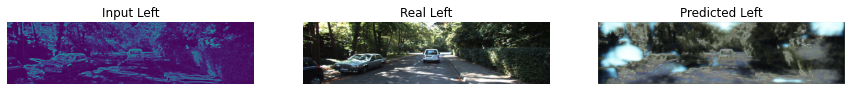

-------- psnr:  13.861904    ----- epoch:  1   count:  100
tf.Tensor(13.861904, shape=(), dtype=float32)


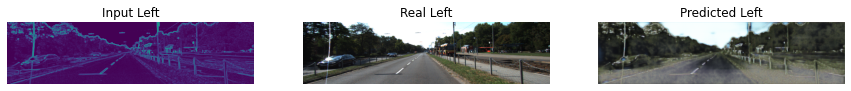

-------- psnr:  14.38985    ----- epoch:  2   count:  100
tf.Tensor(14.38985, shape=(), dtype=float32)


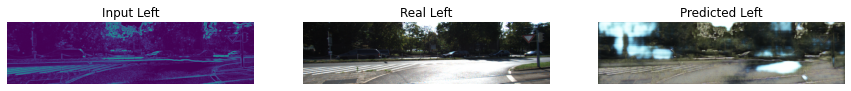

-------- psnr:  14.943411    ----- epoch:  3   count:  100
tf.Tensor(14.943411, shape=(), dtype=float32)


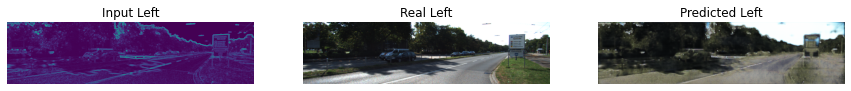

-------- psnr:  14.906931    ----- epoch:  4   count:  100
-------- psnr:  15.386238    ----- epoch:  5   count:  100
tf.Tensor(15.386238, shape=(), dtype=float32)


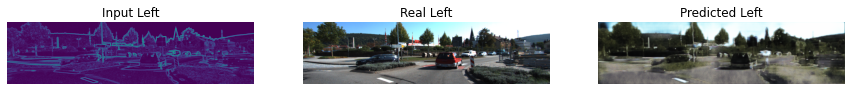

-------- psnr:  15.839801    ----- epoch:  6   count:  100
tf.Tensor(15.839801, shape=(), dtype=float32)


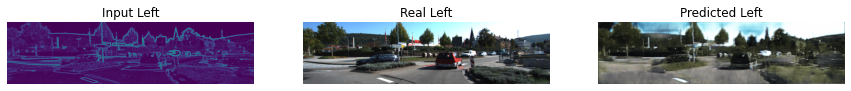

-------- psnr:  15.656689    ----- epoch:  7   count:  100
-------- psnr:  15.5823555    ----- epoch:  8   count:  100
-------- psnr:  15.840558    ----- epoch:  9   count:  100
tf.Tensor(15.840558, shape=(), dtype=float32)


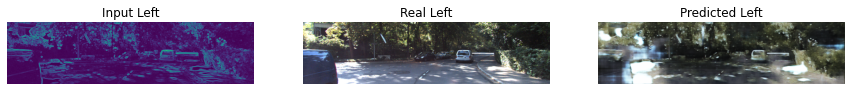

-------- psnr:  16.054956    ----- epoch:  10   count:  100
tf.Tensor(16.054956, shape=(), dtype=float32)


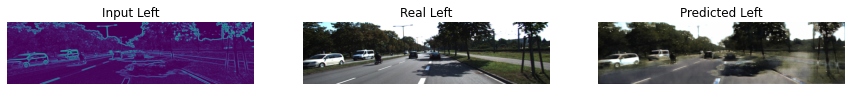

-------- psnr:  15.922506    ----- epoch:  11   count:  100
-------- psnr:  16.348911    ----- epoch:  12   count:  100
tf.Tensor(16.348911, shape=(), dtype=float32)


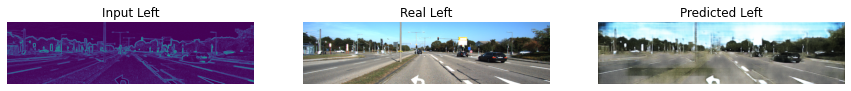

-------- psnr:  16.445349    ----- epoch:  13   count:  100
tf.Tensor(16.445349, shape=(), dtype=float32)


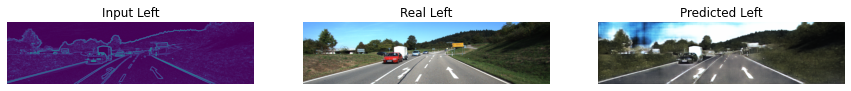

-------- psnr:  16.393553    ----- epoch:  14   count:  100
-------- psnr:  16.479017    ----- epoch:  15   count:  100
tf.Tensor(16.479017, shape=(), dtype=float32)


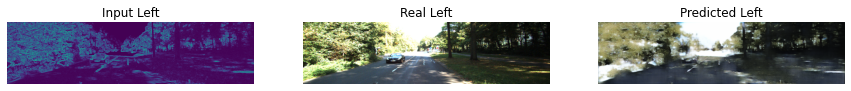

-------- psnr:  16.17718    ----- epoch:  16   count:  100
-------- psnr:  16.512426    ----- epoch:  17   count:  100
tf.Tensor(16.512426, shape=(), dtype=float32)


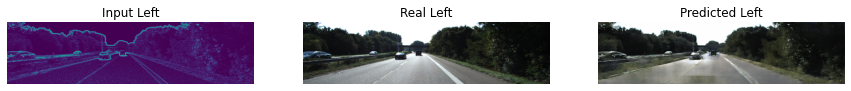

-------- psnr:  16.481937    ----- epoch:  18   count:  100
-------- psnr:  16.754898    ----- epoch:  19   count:  100
tf.Tensor(16.754898, shape=(), dtype=float32)


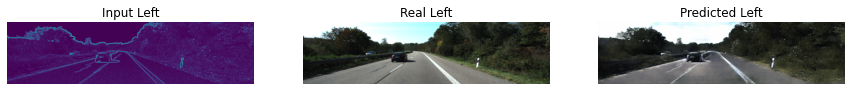

In [34]:
EPOCHS = 20
fit(train_dataset, EPOCHS, test_dataset)

In [35]:
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/AI Insight/Week14/21.2_11.h5')

# Show the model architecture
new_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 1024, 1 0                                            
__________________________________________________________________________________________________
sequential_10 (Sequential)      (None, 256, 1024, 64 832         input_2[0][0]                    
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 128, 512, 64) 65792       sequential_10[0][0]              
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 64, 256, 256) 263168      sequential_11[0][0]              
____________________________________________________________________________________________

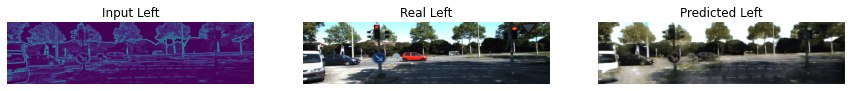

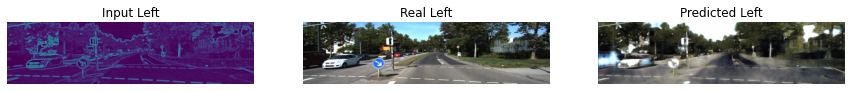

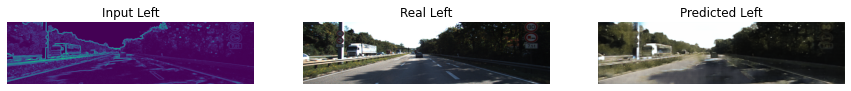

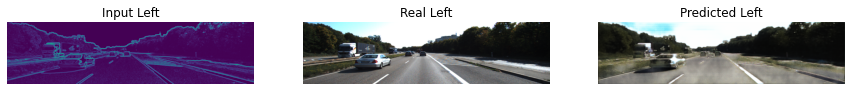

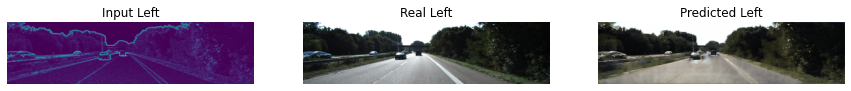

In [36]:
for inp, tar in test_dataset.take(5):
  generate_images(new_model, inp, tar)